In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("../data/data_csv.csv")

In [3]:
df["Year"] = pd.DatetimeIndex(df['Date']).year
df["Month"] = pd.DatetimeIndex(df['Date']).month
start_y = 2000
end_y = 2018

df_new = df[df.Year>=start_y].reset_index(drop=True)
df_new = df_new.drop("Date", axis=1)

In [4]:
vif = pd.DataFrame()
df_vif = df_new
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

                features    vif_Factor
0                  SP500  30554.880871
1               Dividend  54192.804078
2               Earnings   6379.438636
3   Consumer Price Index   8168.074694
4     Long Interest Rate    108.567108
5             Real Price  46656.431890
6          Real Dividend  56584.761389
7          Real Earnings   5764.622216
8                   PE10   3765.205354
9                   Year   9182.814846
10                 Month      4.604038

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


### To calculate real returns we use the formula:
return[t] = return[t-1] * (((Real Price[t] - Real Price[t-1]) / Real Price[t-1])) + 1) + (Real Dividend[t-1]/RealPrice[t-1]) * (return[t-1]/12)

In [5]:
def calculate_real_return(idx, old_idx, previous_return, df_new_s):
    diff_price = ((df_new_s["Real Price"].values[idx] - df_new_s["Real Price"].values[old_idx]) / (df_new_s["Real Price"].values[old_idx])) + 1
    cum_return = previous_return * diff_price
    reinvested_dividens = cum_return + (df_new_s["Real Dividend"].values[old_idx] / df_new_s["Real Price"].values[old_idx]) * (previous_return/12)
    return reinvested_dividens

In [6]:
previous_real_returns = []
previous_real_returns.append(1) # start with investing one dollar at the begining
i = 0

for y in range(len(df_new)-1):
    real_return = calculate_real_return(y+1, y, previous_real_returns[i], df_new) 
    previous_real_returns.append(real_return)
    i += 1

In [7]:
return_val = []
month = 1 # january
i = 0
month_count = []

for idx, row in df_new.iterrows():
    if row.Month == month:
        return_val.append(previous_real_returns[i])
        month_count.append(i)
    else:
        month += 1
        i += 1
        return_val.append(previous_real_returns[i])
        month_count.append(i)

In [8]:
df_new["Return"] = return_val
df_new["InvestedMonths"] = month_count

(array([ 7., 16., 30., 63., 30., 15., 24., 19.,  8.,  4.]),
 array([ 889.28 , 1070.365, 1251.45 , 1432.535, 1613.62 , 1794.705,
        1975.79 , 2156.875, 2337.96 , 2519.045, 2700.13 ]),
 <a list of 10 Patch objects>)

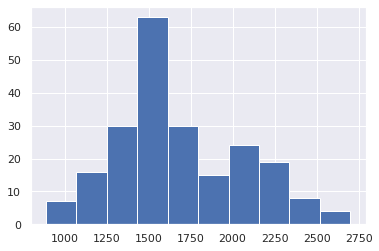

In [9]:
plt.hist(df_new["Real Price"])

(array([22., 21., 22., 21., 22., 21., 22., 21., 22., 22.]),
 array([  0. ,  21.5,  43. ,  64.5,  86. , 107.5, 129. , 150.5, 172. ,
        193.5, 215. ]),
 <a list of 10 Patch objects>)

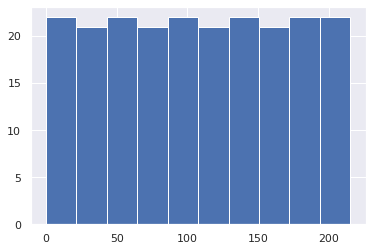

In [10]:
plt.hist(df_new["InvestedMonths"])

(array([20., 36., 55., 45.,  9.,  8., 21., 11.,  7.,  4.]),
 array([ 757.13 ,  947.851, 1138.572, 1329.293, 1520.014, 1710.735,
        1901.456, 2092.177, 2282.898, 2473.619, 2664.34 ]),
 <a list of 10 Patch objects>)

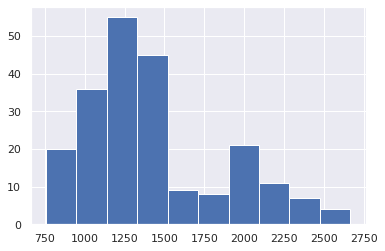

In [11]:
plt.hist(df_new["SP500"])

(array([20., 32., 68., 37.,  9.,  9., 23.,  7.,  7.,  4.]),
 array([0.49416668, 0.62412239, 0.75407811, 0.88403382, 1.01398954,
        1.14394525, 1.27390097, 1.40385668, 1.5338124 , 1.66376811,
        1.79372383]),
 <a list of 10 Patch objects>)

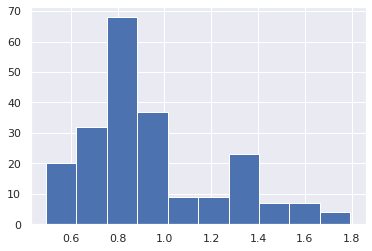

In [12]:
plt.hist(df_new["Return"])

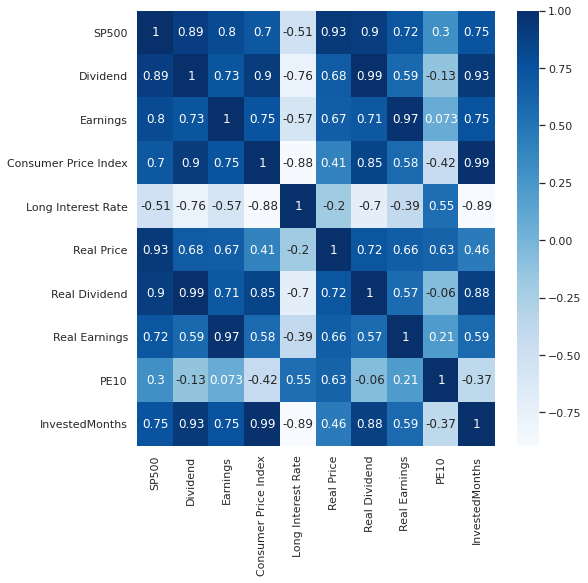

select those independent variables with high correlation with dependent variable


In [13]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_new.drop(["Return", "Year", "Month"], axis=1).corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

print("select those independent variables with high correlation with dependent variable")

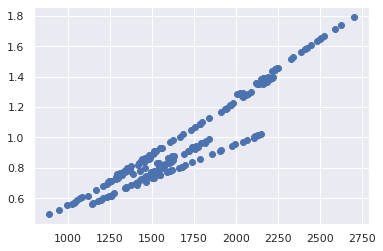

In [14]:
plt.scatter(df_new["Real Price"], df_new["Return"])

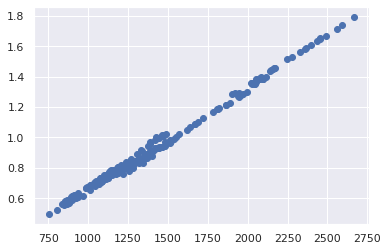

In [15]:
plt.scatter(df_new["SP500"], df_new["Return"])

In [16]:
returns = [math.log(r) for r in df_new["Return"]]

Text(0, 0.5, 'Return')

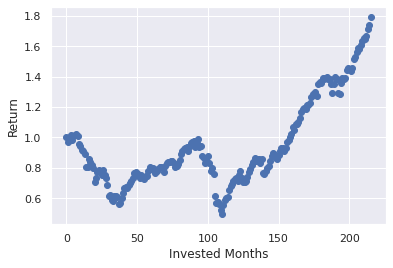

In [17]:
plt.scatter(df_new["InvestedMonths"], df_new["Return"])
plt.xlabel("Invested Months")
plt.ylabel("Return")

Text(0, 0.5, 'Log Return')

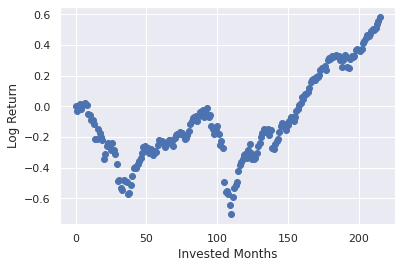

In [18]:
plt.scatter(df_new["InvestedMonths"], returns)
plt.xlabel("Invested Months")
plt.ylabel("Log Return")

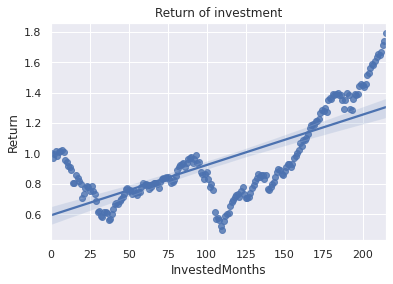

In [19]:
plt.title("Return of investment")
sns.regplot(x="InvestedMonths", y="Return", data=df_new[["InvestedMonths", "Return"]])

Text(0, 0.5, 'Log Return')

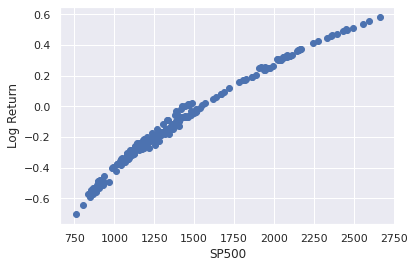

In [20]:
plt.scatter(df_new["SP500"], returns)
plt.xlabel("SP500")
plt.ylabel("Log Return")

In [21]:
vif = pd.DataFrame()
df_vif = df_new[["SP500", "Real Price"]]
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

     features  vif_Factor
0       SP500   74.213667
1  Real Price   74.213667

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


In [22]:
def get_cv_scores(model, x, y):
    scores = cross_val_score(model, x, y, cv=10, scoring='r2')
    
    print(f'CV Mean: {np.mean(scores):.4f}')
    print(f'STD: {np.std(scores):.4f}')

In [23]:
def results(y_t, y_p):
    print(f'Mean squared error: {mean_squared_error(y_t, y_p):.4f}')
    # The coefficient of determination: 1 is perfect prediction
    print(f'Coefficient of determination: {r2_score(y_t, y_p):.4f}')

### Model 1: =  Return ~ SP500

In [24]:
X = df_new[["SP500"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.9928
STD: 0.0037
Mean squared error: 0.0005
Coefficient of determination: 0.9947


In [25]:
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
model.bic

-783.7935309599197

### Model 2: Return ~ InvestedMonths

In [26]:
X = df_new[["InvestedMonths"]]
y = returns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.3534
STD: 0.1658
Mean squared error: 0.0408
Coefficient of determination: 0.5641


In [27]:
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
model.bic

-39.804351163210114

### Model 3: Return ~ SP500+RealPrice

In [28]:
X = df_new[["SP500", "Real Price"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.9957
STD: 0.0022
Mean squared error: 0.0003
Coefficient of determination: 0.9966


### Model 4: Return ~ All features

In [29]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.9999
STD: 0.0000
Mean squared error: 0.0000
Coefficient of determination: 1.0000


In [30]:
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
model.bic

-1513.8354034554247

#### From results above we could see that feature "Invested Years" doesn't improve our model so we could exclude it in future analysis.

## Using PCA to transform features

In [31]:
def transform_features(num_components, X_tr, X_te):
    scaler = MinMaxScaler()
    X_train_minmax = scaler.fit_transform(X_tr)
    X_test_minmax = scaler.transform(X_te)
    
    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train_minmax)
    X_test_pca = pca.transform(X_test_minmax)
    return pca, X_train_pca, X_test_pca

In [32]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

pca, X_train_pca, X_test_pca = transform_features(0.99, X_train, X_test)

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
get_cv_scores(lr, X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.9905
STD: 0.0025
Mean squared error: 0.0008
Coefficient of determination: 0.9919


In [33]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.bic

-712.0082263357128

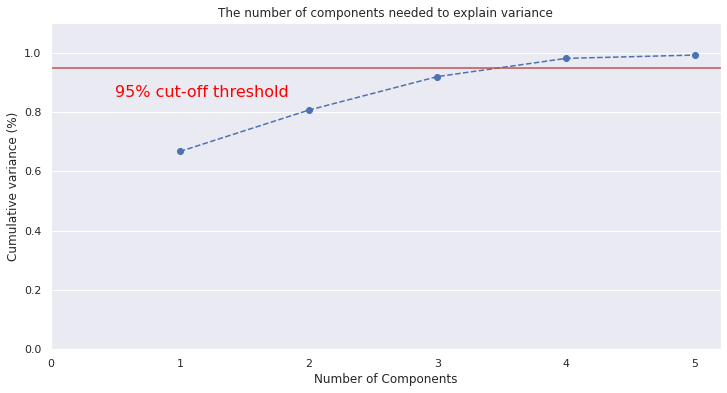

In [34]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
end_d = 6
xi = np.arange(1, end_d, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, end_d, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### From the plot above we could see that number of components is between 3 and 4.

### Model 5: Return ~ PCA  with 3 components

In [35]:
y = df_new[["Return"]]
X = df_new.drop(["Return", "Year", "Month", "PE10", "Long Interest Rate"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# X_train_months = X_train["InvestedMonths"]
# X_test_months = X_test["InvestedMonths"]

# X_train = X_train.drop("InvestedMonths", axis=1)
# X_test = X_test.drop("InvestedMonths", axis=1)

pca, X_train_pca, X_test_pca = transform_features(3, X_train, X_test) # try with 3 components

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
get_cv_scores(lr, X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.9769
STD: 0.0081
Mean squared error: 0.0015
Coefficient of determination: 0.9844


In [36]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.bic

-579.6964408171979

In [37]:
df1 = pd.concat([X_train[["InvestedMonths"]], y_train], join = 'outer', axis = 1).reset_index(drop=True)

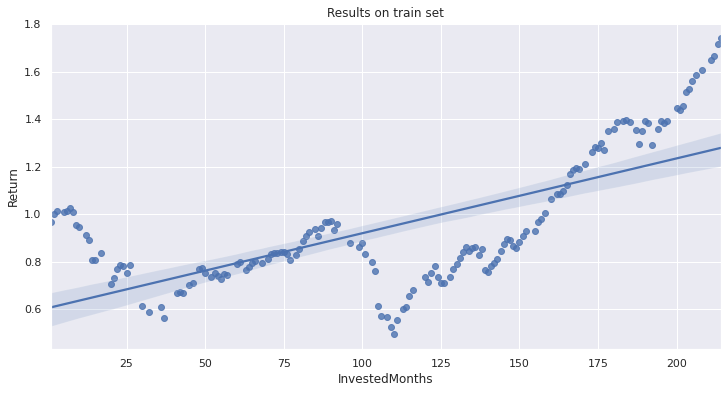

In [38]:
plt.title("Results on train set")
sns.regplot(x="InvestedMonths", y="Return", data=df1)

In [39]:
import itertools

test_return = pd.DataFrame({'Return': list(itertools.chain.from_iterable(y_pred.tolist()))})

In [40]:
df2 = pd.concat([X_test[["InvestedMonths"]].reset_index(drop=True), test_return], join = 'outer', axis = 1).reset_index(drop=True)

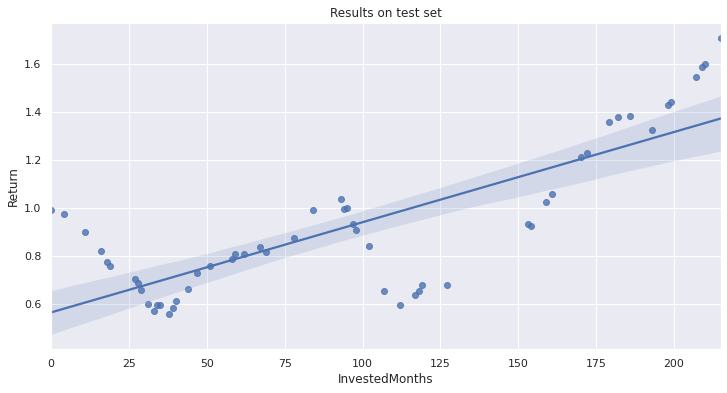

In [41]:
plt.title("Results on test set")
sns.regplot(x="InvestedMonths", y="Return", data=df2)